# 1. Import Dependencies and Setup

In [2]:
import tensorflow as tf

In [3]:
tf.__version__

'2.12.0'

In [4]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [5]:
tf.config.list_physical_devices('GPU')

[]

# 2. Remove bad data

In [6]:
import cv2
import imghdr
import os

In [7]:
data_dir = 'dataset' 

In [8]:
image_exts = ['jpeg','jpg', 'bmp', 'png']

In [9]:
# delete images in strange formats and that fail to load
for image_class in os.listdir(data_dir): 
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try: 
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts: 
                print(f'Image not in ext list {image_path}')
                os.remove(image_path)
        except Exception as e: 
            print(f'Issue with image {image_path}')
            os.remove(image_path)

# 3. Load Data

In [10]:
import numpy as np
from matplotlib import pyplot as plt

In [11]:
# Default values: batch_size = 32, shuffle = true, image_size = 256x256...
data = tf.keras.utils.image_dataset_from_directory('dataset')

Found 2654 files belonging to 2 classes.


In [12]:
data_iterator = data.as_numpy_iterator()

In [13]:
#images represented as numpy arrays
batch = data_iterator.next()

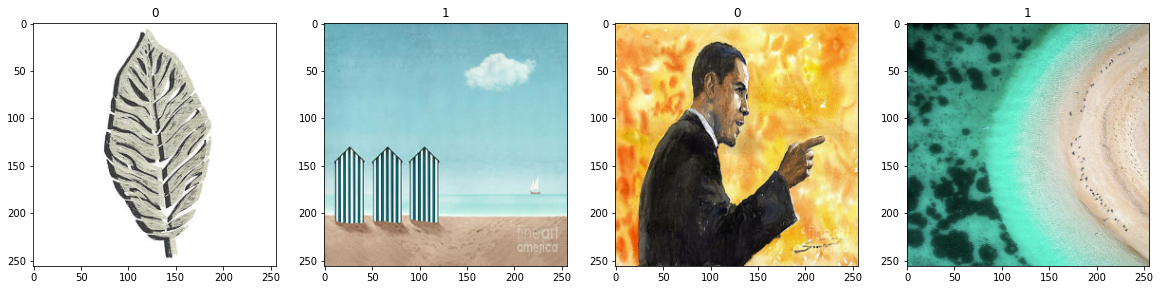

In [14]:
# Class 1 = Sad
# Class 0 = Happy
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

# 4. Scale Data

In [15]:
# Divides all RGB pixel values of every image by 255 to compress them between 0 and 1
# x are the images in the date pipeline, y are the labels/classes (which are set based on the folder the image is in)
data = data.map(lambda x,y: (x/255, y))

In [16]:
scaled_batch = data.as_numpy_iterator().next()

In [17]:
scaled_batch

(array([[[[0.67610675, 0.6604205 , 0.66434205],
          [0.6883454 , 0.6726591 , 0.67658067],
          [0.66242343, 0.64673716, 0.6506587 ],
          ...,
          [0.5095521 , 0.501709  , 0.5213168 ],
          [0.5663699 , 0.55852675, 0.5781346 ],
          [0.57426566, 0.5664225 , 0.58603036]],
 
         [[0.6832031 , 0.6675168 , 0.6648208 ],
          [0.6160846 , 0.6003983 , 0.5977022 ],
          [0.6118767 , 0.59619045, 0.59349436],
          ...,
          [0.59432256, 0.5864794 , 0.60608727],
          [0.5219755 , 0.5141324 , 0.5337402 ],
          [0.48837602, 0.48053288, 0.5001407 ]],
 
         [[0.72562325, 0.709937  , 0.7028292 ],
          [0.70833236, 0.6926461 , 0.68553823],
          [0.69434935, 0.6786631 , 0.6715552 ],
          ...,
          [0.5091471 , 0.501304  , 0.5209118 ],
          [0.503417  , 0.49557388, 0.5151817 ],
          [0.5493729 , 0.5415298 , 0.5611376 ]],
 
         ...,
 
         [[0.39253503, 0.11496151, 0.19179974],
          [0.39248

In [18]:
scaled_batch[0].min()

0.0

In [19]:
scaled_batch[0].max()

1.0

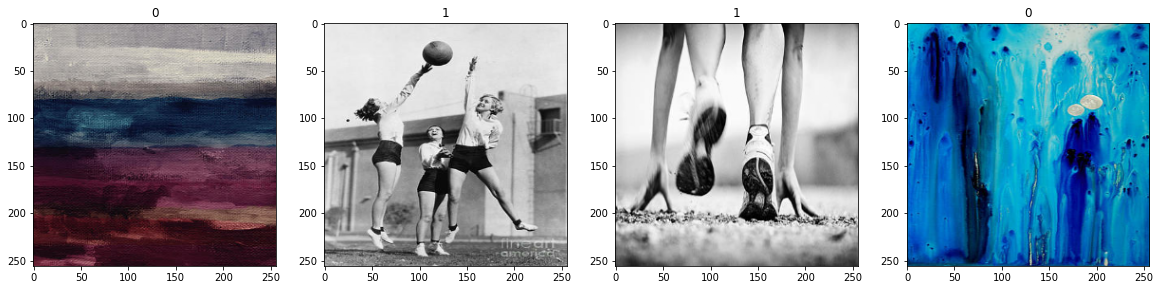

In [20]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(scaled_batch[0][:4]):
    ax[idx].imshow(img)
    ax[idx].title.set_text(scaled_batch[1][idx])

# 5. Split Data

In [21]:
# number of batches (with 32 images each) in our data
len(data)

83

In [22]:
train_size = int(len(data)*.7)
val_size = int(len(data)*.2)+1
test_size = int(len(data)*.1)

In [23]:
train_size + val_size + test_size

83

In [24]:
# data is already shufled
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

# 6. Build Deep Learning Model

In [25]:
train

<_TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [26]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, Attention

In [27]:
model = Sequential()

In [28]:
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())

model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Dropout(0.25))  # Add Dropout layer with dropout rate of 25%
model.add(Flatten())

model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))  # Add Dropout layer with dropout rate of 50%
model.add(Dense(1, activation='sigmoid'))

In [29]:
optimizer = tf.keras.optimizers.Adam(lr=0.01)
model.compile(optimizer, loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [30]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 30, 30, 16)       0

# 7. Train

In [31]:
logdir='logs'

In [32]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [33]:
hist = model.fit(train, epochs=15, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/15


58/58 [==============================] - 27s 445ms/step - loss: 0.6432 - accuracy: 0.6428 - val_loss: 0.7210 - val_accuracy: 0.6710
Epoch 2/15
58/58 [==============================] - 25s 433ms/step - loss: 0.5764 - accuracy: 0.7198 - val_loss: 0.6546 - val_accuracy: 0.6838
Epoch 3/15
58/58 [==============================] - 26s 440ms/step - loss: 0.5219 - accuracy: 0.7398 - val_loss: 0.5115 - val_accuracy: 0.7518
Epoch 4/15
58/58 [==============================] - 26s 451ms/step - loss: 0.4754 - accuracy: 0.7769 - val_loss: 0.4657 - val_accuracy: 0.7721
Epoch 5/15
58/58 [==============================] - 26s 446ms/step - loss: 0.4306 - accuracy: 0.8001 - val_loss: 0.4750 - val_accuracy: 0.7610
Epoch 6/15
58/58 [==============================] - 28s 473ms/step - loss: 0.3666 - accuracy: 0.8254 - val_loss: 0.4540 - val_accuracy: 0.8015
Epoch 7/15
58/58 [==============================] - 26s 446ms/step - loss: 0.3072 - accuracy: 0.8750 - val_loss: 0.5746 - val_accuracy: 0.7647
Epoch 8/15

In [37]:
optimizer.learning_rate.assign(0.001)
hist = model.fit(train, initial_epoch=15, epochs=30, validation_data=val, callbacks=[tensorboard_callback])

Epoch 16/30
58/58 [==============================] - 26s 447ms/step - loss: 0.1049 - accuracy: 0.9666 - val_loss: 0.5175 - val_accuracy: 0.8474
Epoch 17/30
58/58 [==============================] - 26s 446ms/step - loss: 0.0634 - accuracy: 0.9768 - val_loss: 0.5338 - val_accuracy: 0.8566
Epoch 18/30
58/58 [==============================] - 25s 427ms/step - loss: 0.0544 - accuracy: 0.9844 - val_loss: 0.6248 - val_accuracy: 0.8585
Epoch 19/30
58/58 [==============================] - 26s 448ms/step - loss: 0.0564 - accuracy: 0.9784 - val_loss: 0.5873 - val_accuracy: 0.8676
Epoch 20/30
58/58 [==============================] - 27s 454ms/step - loss: 0.0449 - accuracy: 0.9892 - val_loss: 0.6018 - val_accuracy: 0.8585
Epoch 21/30
58/58 [==============================] - 25s 429ms/step - loss: 0.0429 - accuracy: 0.9881 - val_loss: 0.6656 - val_accuracy: 0.8676
Epoch 22/30
58/58 [==============================] - 26s 445ms/step - loss: 0.0310 - accuracy: 0.9914 - val_loss: 0.6432 - val_accuracy:

# 8. Plot Performance

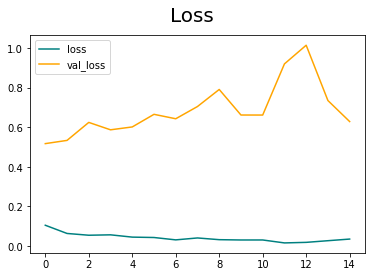

In [38]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

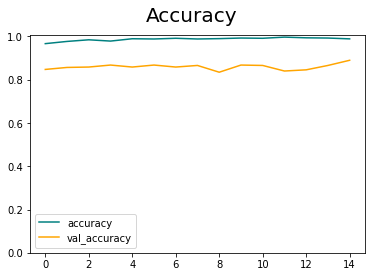

In [62]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="lower left")
plt.ylim(ymin=0)
plt.show()

# 9. Evaluate

In [40]:
from keras.metrics import Precision, Recall, BinaryAccuracy, TruePositives, FalsePositives, TrueNegatives, FalseNegatives

In [41]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [42]:
yList = []
yhatList = []
for batch in test.as_numpy_iterator(): 
    X, y = batch
    yhat = model.predict(X)

    yList.extend(y)
    yhatList.extend(np.around(yhat))

    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

1/1 [==============================] - 0s 101ms/step


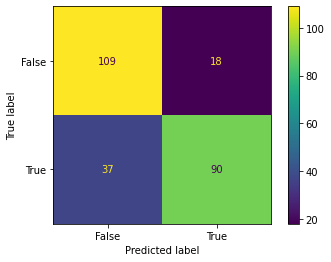

In [43]:
from sklearn import metrics as skmetrics

cm = skmetrics.confusion_matrix(yList, yhatList)

cm_display = skmetrics.ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = [False, True])

cm_display.plot()
plt.show()

In [44]:
f1score = 2 * pre.result().numpy() * re.result().numpy() / (pre.result().numpy() + re.result().numpy()) 

In [45]:
print(f'Precision: {pre.result().numpy()}, Recall: {re.result().numpy()}, Accuracy: {acc.result().numpy()}, F1 Score: {f1score}')

Precision: 0.8333333134651184, Recall: 0.7086614370346069, Accuracy: 0.7834645509719849, F1 Score: 0.7659574203223548


# 10. Test

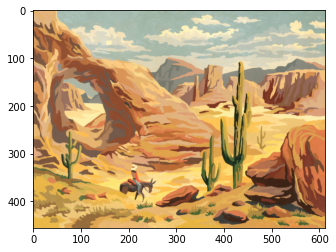

In [46]:
img = cv2.cvtColor(cv2.imread('painting.jpg'), cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.show()

#fig, ax = plt.subplots(ncols=2, figsize=(20,20))
#for idx, img in enumerate(images):
    #ax[idx].imshow(img.astype(int))

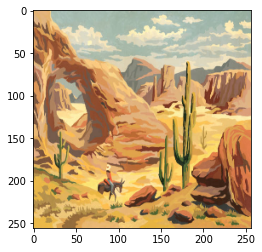

In [47]:
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

#resized = [tf.image.resize(img, (256,256)) for img in images]

#fig, ax = plt.subplots(ncols=2, figsize=(20,20))
#for idx, img in enumerate(resized):
    #ax[idx].imshow(img.numpy().astype(int))

In [48]:
yhat = model.predict(np.expand_dims(resize/255, 0))

#pred1 = model.predict(np.expand_dims(resized[0]/255, 0))
#pred2 = model.predict(np.expand_dims(resized[1]/255, 0))

1/1 [==============================] - 0s 18ms/step


In [49]:
yhat
#pred1, pred2

array([[7.498103e-05]], dtype=float32)

In [51]:
if yhat > 0.5: 
    print('Predicted class is a PHOTO')
else:
    print('Predicted class is a PAINTING')

Predicted class is a PAINTING


# 11. Save the Model

In [52]:
from keras.models import load_model

In [53]:
model.save(os.path.join('models','paintingorphoto.h5'))

In [54]:
new_model = load_model(os.path.join('models','paintingorphoto.h5'))

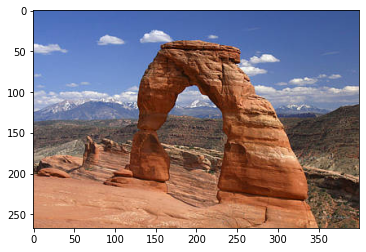

In [56]:
imgTest = cv2.cvtColor(cv2.imread('photo.jpg'), cv2.COLOR_BGR2RGB)
plt.imshow(imgTest)
plt.show()

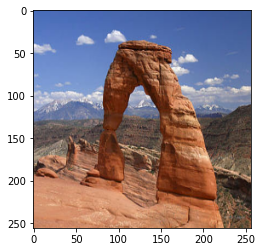

In [57]:
resizeTest = tf.image.resize(imgTest, (256,256))
plt.imshow(resizeTest.numpy().astype(int))
plt.show()

In [58]:
yhatnew = new_model.predict(np.expand_dims(resizeTest/255, 0))
print(yhatnew)

1/1 [==============================] - 0s 49ms/step
[[0.99996084]]


In [60]:
if yhatnew > 0.5: 
    print('Predicted class is a PHOTO')
else:
    print('Predicted class is a PAINTING')

Predicted class is a PHOTO
